
<img src="dat/estaes.png">



 
## Paso 1: Extraer la información y cargar data:

In [ ]:
#####################################################################################
# ANALISIS DE USUARIOS Y HOSTES
#####################################################################################
import pandas as pd
import folium
#####################################################################################
############################
#----- Carga de datos -----#
############################

ciudades = ['Barcelona', 'Euskadi', 'Girona', 'Madrid', 'Malaga', 'Mallorca', 'Menorca', 
            'Sevilla', 'Valencia']
tmp = []
for i in range(len(ciudades)):
    a = 'listings_'
    b = ciudades[i]
    c = '.csv'
    d = a+b+c
    res = pd.read_csv('dat/'+d, encoding="UTF-8", parse_dates = ['last_review'], dtype = {"price":"float"})
    res['ciudad']= b
    tmp.append(res)

usuarios =pd.DataFrame([])
for i in range(len(ciudades)):
    usuarios = usuarios.append(tmp[i])
usuarios.rename(columns={"id": "id_usuario", "name": "nombre", "host_id": "id_host", 
                         "host_name": "nombre_host","neighbourhood_group":"grupo", 
                         "neighbourhood": "barrio", "latitude": "latitud", 
                         "longitude": "longitud", "room_type": "tipo_habitacion",
                         "price": "precio", "minimum_nights": "noches_minimas",
                         "number_of_reviews": "numero_visitas","last_review":"ultima_visita",
                         "reviews_per_month":"visitas_mes",
                         "calculated_host_listings_count": "lista_host", 
                         "availability_365": "disponibilidad"}, inplace=True)

#Seleccionar ciudad
usuarios = usuarios[usuarios.ciudad.isin(['Barcelona'])]
usuarios

## Paso 2 : Calculamos la cantidad de barrios a analizar

In [39]:
barrios = usuarios.groupby('barrio').id_host.count()
cantidad_barrios = len(barrios) 
cantidad_barrios

71

## Paso 3 : Calculamos la cantidad de hostes por barrio

In [40]:
hostes_por_barrio = pd.DataFrame(barrios)
hostes_por_barrio = hostes_por_barrio.rename(columns={"id_host": "Cantidad hostes"})
hostes_por_barrio

,Cantidad hostes
barrio,
Baró de Viver,2
Can Baró,43
Can Peguera,2
Canyelles,4
Ciutat Meridiana,7
...,...
la Vila Olímpica del Poblenou,190
la Vila de Gràcia,1112
les Corts,240



<img src="dat/nacional5.jpg">

## Paso 4 : Encontramos el top 5 de los barrios más populares

In [53]:
# Calculando la cantidad de Barrios a analizar  -- 71 --
usuarios_barrio = usuarios.groupby('barrio').id_usuario.count()
usu_bar = len(usuarios_barrio) 
usu_bar

# Calcular la cantidad de airbnb(usuarios) por barrio
usu_por_barrio = pd.DataFrame(usuarios_barrio)
usu_por_barrio

# Top 5 donde mas usuarios hay por Barrio    -- barrio más popular --
lista_barrios_usu = pd.DataFrame(usu_por_barrio)
barrios_top_usu = lista_barrios_usu.sort_values('id_usuario', ascending=False).reset_index().head()
barrios_top_usu = barrios_top_usu.rename(columns={"id_usuario": "Usuarios por barrio"})
barrios_top_usu

,barrio,Usuarios por barrio
0,la Dreta de l'Eixample,2076
1,el Raval,1766
2,el Barri Gòtic,1367
3,"Sant Pere, Santa Caterina i la Ribera",1248
4,el Poble Sec,1128


## Gráfica en funcion del precio por barrios

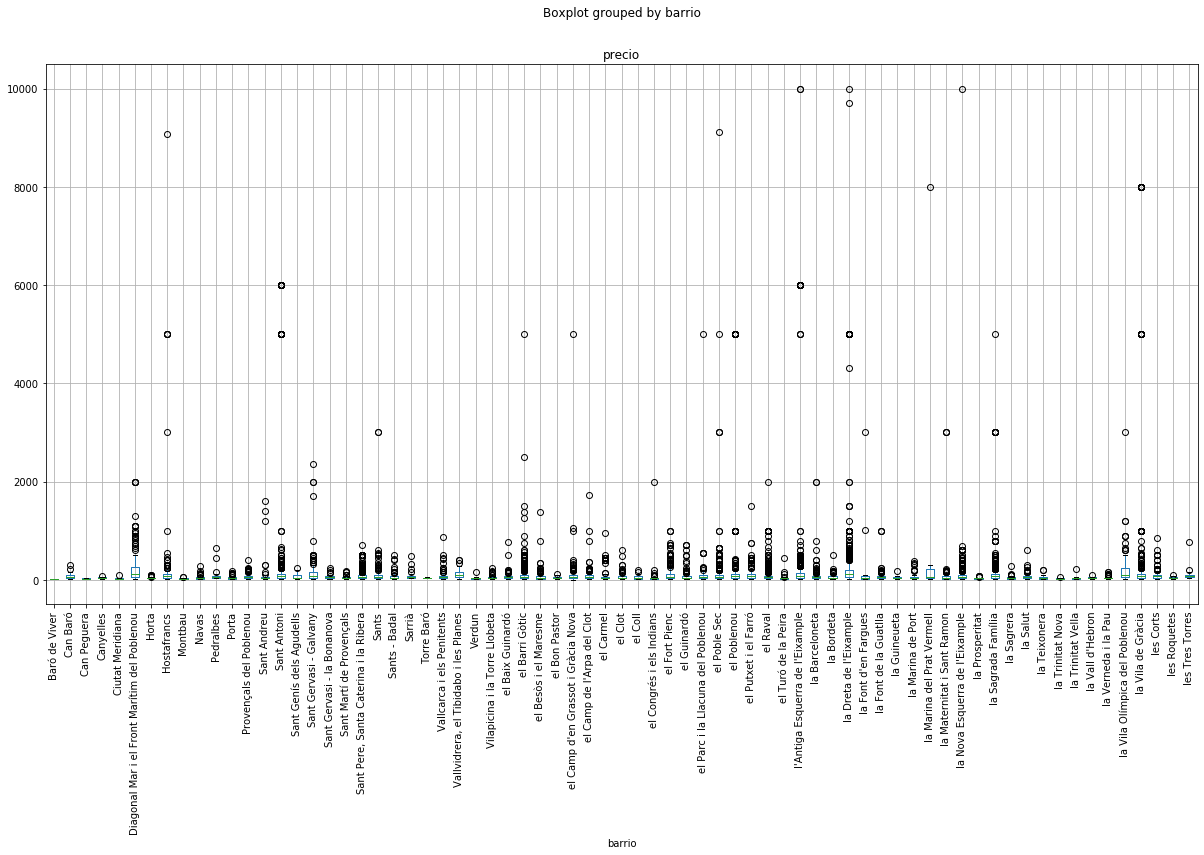

In [42]:
%matplotlib inline

out = usuarios.boxplot('precio', by='barrio', figsize=(20, 10), rot=90)

## Paso 5: Mapa de los barrios más populares

In [44]:
# Debemos calcular la media de la longitud y latitud de los barrios más populares para poder pintarlos
top_barrios = barrios_top_usu.barrio
def coordenadas(top_barrios):
    coor = [] * len(top_barrios)
    for barrio in range(len(top_barrios)):  
        barrio= usuarios[usuarios.barrio == top_barrios[barrio]]
        media_latitud = barrio.latitud.mean()
        media_longitud = barrio.longitud.mean()
        coor.append(media_latitud)
        coor.append(media_longitud)
        
    return coor
coordenadas = coordenadas(top_barrios)

In [45]:
# Pintar el mapa con los barrios más populares 
loc = [41.3887901, 2.1589899]
map_barcelona = folium.Map(location=loc, zoom_start=13)

# Asigna latitud y longitud de los top5 a la tabla, llamando la funcion coordenadas
latitud = coordenadas[0::2]
longitud = coordenadas[1::2]

cruce = pd.DataFrame({'barrio': barrios_top_usu.barrio,
                      'latitud':latitud,
                      'longitud': longitud
                    })

# Tomo los 5 barrios más populares y los pinto
colores = { "la Dreta de l'Eixample" : "red",
            "el Raval" : "green",
            "el Barri Gòtic" : "blue",
            "Sant Pere, Santa Caterina i la Ribera" : "pink",
            "el Poble Sec" : "orange"
          }
  
cruce.apply(lambda row: folium.Marker([row.latitud, row.longitud] ,tooltip=row.barrio, radius=3).add_to(map_barcelona),axis=1)
cruce.apply(lambda row: folium.CircleMarker([row.latitud, row.longitud],color=colores[row.barrio] ,tooltip=row.barrio, radius=3).add_to(map_barcelona),axis=1)

map_barcelona

In [54]:
mapa = folium.Map(location = loc, zoom_start =11, tiles ='cartodbpositron')

bins = [0, 10, 100, 1000, 10000]

folium.Choropleth(
    geo_data='dat/neighbourhoods.geojson',
    data=barrios_top_usu,
    columns=['barrio', 'Usuarios por barrio'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlGn',
    bins=bins
).add_to(mapa)
mapa

## Paso 6 : Hostes más populares

In [52]:
# Hostes populares del barrio más popular
top_barrios = barrios_top_usu.barrio
def hostes_mas_populares_barrio (top_barrios):
    hostes = []
   
    for barrio in range(len(top_barrios)):  
        barrio= usuarios[usuarios.barrio == top_barrios[barrio]]
        usuarios_por_host = barrio.groupby('id_host').id_usuario.count()
        usuarios_por_host = pd.DataFrame(usuarios_por_host)
        host_popular = usuarios_por_host.sort_values('id_usuario', ascending=False).reset_index().head()
        hostes.append(host_popular)
        todos = pd.concat(hostes, axis=1)
        
    return todos

todos = hostes_mas_populares_barrio(top_barrios)
todos = todos.rename(columns={"id_host": "id usuarios","id_usuario": "cantidad usuarios por host"})
todos



,id usuarios,cantidad usuarios por host,id usuarios,cantidad usuarios por host,id usuarios,cantidad usuarios por host,id usuarios,cantidad usuarios por host,id usuarios,cantidad usuarios por host
0,102947901,41,208199613,15,7843388,29,102947901,34,214774673,21
1,158023606,33,47171261,15,102947901,28,193618270,26,170716140,17
2,43565515,31,143696785,14,1503151,20,3775349,22,1447144,15
3,10547296,28,260532837,14,1447144,18,139063900,15,4459553,15
4,5878688,26,170716140,13,396363,16,1447144,15,6538012,14


## Paso 7 :  Calculamos el top 5 de los hostes que más usuarios tienen en Barcelona

In [352]:
# Top 5 de los hostes que más usuarioa tienen en Barcelona
usuarios_por_host_todo = usuarios.groupby('id_host').id_usuario.count()
usuarios_por_host_todo = pd.DataFrame(usuarios_por_host_todo)
host_popular_todo = usuarios_por_host_todo.sort_values('id_usuario', ascending=False).reset_index().head()
host_popular_todo = host_popular_todo.rename(columns={"id_usuario": "Cantidad de usuarios"})
host_popular_todo

,id_host,Cantidad de usuarios
0,102947901,153
1,4459553,132
2,170716140,131
3,193618270,120
4,171236207,115


## Paso 8 : Período más visitado

In [18]:
perido = usuarios.groupby('ultima_visita').id_host.count()

periodo = pd.DataFrame(perido)
mas_visitado = periodo.sort_values('id_host', ascending=False).reset_index().head()
mes_mas_visitado = mas_visitado.rename(columns={"ultima_visita":"mes mas visitado","id_host": "Cantidad de comentarios"})
mes_mas_visitado.head(1)

,mes mas visitado,Cantidad de comentarios
0,2019-09-01,538


## Paso 9 : Analizar la data obtenida

- Los datos obtenidos al calcular los hostes que más usuarios tiene en Barcelona en su totalidad frente a los hostes más populares evidentemente muestra que el Top de los barrios más populares contiene a los hostes que más usuarios han tenido a lo largo del tiempo.

- El mes más visitado es septiembre con base en la información obtenida en el análisis que realizamos paso a paso.

- El host mas popular es quien tiene el id 102947901 quien a lo largo del tiempo ha tenido 153 usuarios